In [1]:
import igraph as ig
from typing import Dict, List
import matplotlib.pyplot as plt
import overpy

In [2]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [3]:
from scripts.config import Config

In [4]:
def eval_way(way, config: Config = Config()):
    score = 0
    max_score = config.weight_sum()
    for tag, value in way.tags.items():
        weight, mapping = config[tag]
        score += weight * mapping.get(value, 0)
    return score / max_score

In [5]:
def ways_to_edges(ways: List[overpy.Way]):
    link_counter: Dict[str, int] = {}
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        for node in nodes:
            link_counter[node.id] = link_counter.get(node.id, 0) + 1

    edges = []
    all_nodes = set()
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        if len(nodes) == 2:
            edges.append([nodes[0].id, nodes[1].id])  # add way as an edge
            all_nodes.add(nodes[0].id)
            all_nodes.add(nodes[1].id)
            continue
        head = nodes[0]
        tail = nodes[len(nodes) - 1]
        prev = head
        for i in range(1, len(nodes) - 1):
            node = nodes[i]
            if link_counter[node.id] > 1:
                # break the way on node
                edges.append([prev.id, node.id])
                all_nodes.add(prev.id)
                all_nodes.add(node.id)
                prev = node
                if i == len(nodes) - 2:
                    edges.append([node.id, tail.id])
                    all_nodes.add(tail.id)
    return edges, list(all_nodes)

In [6]:
api = overpy.Overpass()
result = api.query("nwr(56.3284, -2.8350, 56.3437, -2.7855); out;")  # st andrews
# result = api.query("nwr(56.3375, -2.8059, 56.3437, -2.7855); out;")

In [7]:
tag_count = {}
for way in result.ways:
    for tag in way.tags:
        tag_count[tag] = tag_count.get(tag, 0) + 1
dict(sorted(tag_count.items(), key=lambda item: item[1]))

{'parking:left:orientation': 1,
 'parking:right:orientation': 1,
 'contact:phone': 1,
 'source:addr': 1,
 'noexit': 1,
 'wikimedia_commons': 1,
 'cycleway:right:segregated': 1,
 'internet_access:fee': 1,
 'internet_access:operator': 1,
 'internet_access:ssid': 1,
 'direction': 1,
 'tactile_paving': 1,
 'culvert': 1,
 'theatre': 1,
 'maxweightrating': 1,
 'garden:type': 1,
 'listed_status': 1,
 'self_service': 1,
 'diet:vegan': 1,
 'diet:vegetarian': 1,
 'telecom': 1,
 'building:condition': 1,
 'castle_type': 1,
 'historic:civilization': 1,
 'supervised': 1,
 'trail_visibility': 1,
 'government': 1,
 'office': 1,
 'bus': 1,
 'naptan:AtcoCode': 1,
 'public_transport': 1,
 'maxstay': 1,
 'information': 1,
 'parking:orientation': 1,
 'wetland': 1,
 'disused:man_made': 1,
 'trade': 1,
 'smoking': 1,
 'emergency': 1,
 'healthcare': 1,
 'recycling:glass_bottles': 1,
 'fee:amount': 1,
 'female': 1,
 'male': 1,
 'ramp:wheelchair': 1,
 'building_1': 1,
 'start_date': 1,
 'craft': 1,
 'compressed

In [8]:
highway_count = {}
for way in result.ways:
    for tag, value in way.tags.items():
        if tag == 'highway':
            highway_count[value] = highway_count.get(value, 0) + 1
dict(sorted(highway_count.items(), key=lambda item: item[1]))

{'construction': 2,
 'secondary': 12,
 'pedestrian': 12,
 'track': 14,
 'cycleway': 28,
 'path': 30,
 'unclassified': 40,
 'primary': 42,
 'tertiary': 43,
 'steps': 62,
 'residential': 252,
 'service': 518,
 'footway': 588}

In [9]:
ways = []
total = 0
ones = 0
for way in result.ways:
    score = eval_way(way)
    total += 1
    if score > 0:
        ones += 1
        ways.append(way)
print(total, ones)

7253 1571


In [10]:
edges, all_nodes = ways_to_edges(ways)
node_mapping = {node_id: idx for idx, node_id in enumerate(all_nodes)}
mapped_edges = [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in edges]

In [11]:
print(len(edges))
print(len(all_nodes))

2340
2265


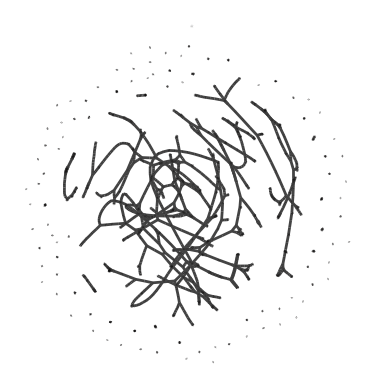

In [12]:
g = ig.Graph(n=len(all_nodes), edges=mapped_edges)
fig, ax = plt.subplots()
ig.plot(g, target=ax)
plt.show()

In [13]:
g.vcount()

2265

In [14]:
g.ecount()

2340

In [18]:
g.edge_connectivity()

0

In [15]:
g.vertex_connectivity()

0

In [16]:
g.clique_number()

3

In [22]:
g.components()

<Axes: >

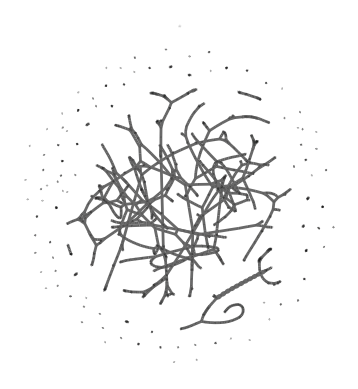

In [26]:
fig, ax = plt.subplots()
ig.plot(g.connected_components(), target=ax)

<Axes: >

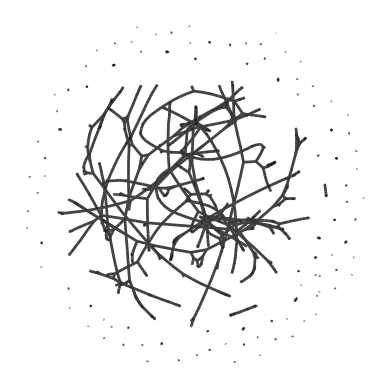

In [30]:
fig, ax = plt.subplots()
ig.plot(g.simplify(), target=ax)